In [ ]:
from google.colab import drive

drive.mount('/gdrive')
%cd /gdrive/My Drive/[2024-2025] ANN2DL/Homework 1

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/My Drive/[2024-2025] ANN2DL/Homework 1


In [ ]:
%%writefile requirements.txt
tensorflow==2.17.0
keras==3.4.1

Overwriting requirements.txt


In [ ]:
!pip install -r requirements.txt

# Import Libraries

In [ ]:
# Set seed for reproducibility
seed = 36

# Import necessary libraries
import os

# Set environment variables before importing modules
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np
import pandas as pd
# Set seeds for random number generators in NumPy and Python
np.random.seed(seed)
random.seed(seed)

import tensorflow as tf
import keras as tfk
from keras.layers import Input, Dense, Dropout, Lambda, GlobalAveragePooling2D, BatchNormalization
from keras import layers as tfkl

print(f"Tensorflow version -> {tf.__version__}")
print(f"Keras version -> {tfk.__version__}")
# Set seed for TensorFlow
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Reduce TensorFlow verbosity
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Print TensorFlow version
print(tf.__version__)

# Import other libraries
import requests
from io import BytesIO
import cv2
from PIL import Image
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

Tensorflow version -> 2.17.1
Keras version -> 3.5.0
2.17.1


# Load and process the data

In [ ]:
# Load the training data here
data = np.load('training_set.npz')
X = data['images']
y = data['labels']
print(X.shape)
print(y.shape)

(13759, 96, 96, 3)
(13759, 1)


In [ ]:
# This function identifies and keeps only the unique rows in the dataset to remove duplicates
X, indices = np.unique(X, return_index=True, axis=0)
y = y[indices]
print(X.shape)
print(y.shape)

(11953, 96, 96, 3)
(11953, 1)


In [ ]:
# indices of the two outliers
intruso_idx = 1008
intruso2_idx = 58

# delete the image from the array X
X = np.delete(X, intruso_idx, axis=0)

# delete its corresponding label from the array y
y = np.delete(y, intruso_idx, axis=0)

X = np.delete(X, intruso2_idx, axis=0)
y = np.delete(y, intruso2_idx, axis=0)

print(f"Nuova shape di X: {X.shape}")
print(f"Nuova shape di y: {y.shape}")

Nuova shape di X: (11951, 96, 96, 3)
Nuova shape di y: (11951, 1)


In [ ]:
# Split data into train_val and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, random_state=seed, test_size=0.2, stratify=np.argmax(y, axis=1))

print(f"X_train_val shape: {X_train_val.shape}, y_train_val shape: {y_train_val.shape}")
print(f"X_train_val shape: {X_train_val.shape}, y_train_val shape: {y_train_val.shape}\n")

print('Counting occurrences of target classes:')
print(pd.DataFrame(y_train_val, columns=['digit'])['digit'].value_counts())

X_train_val shape: (9560, 96, 96, 3), y_train_val shape: (9560, 1)
X_train_val shape: (9560, 96, 96, 3), y_train_val shape: (9560, 1)

Counting occurrences of target classes:
digit
6    1902
1    1718
3    1602
7    1336
2     859
5     790
4     692
0     661
Name: count, dtype: int64


# Inspect data

In [ ]:
# Define a mapping of labels to their corresponding digit names
labels = {0:'Basophil', 1:'Eosinophil', 2:'Erythroblast', 3:'Immature granulocytes', 4:'Lymphocyte', 5:'Monocyte', 6:'Neutrophil', 7:'Platelet'}

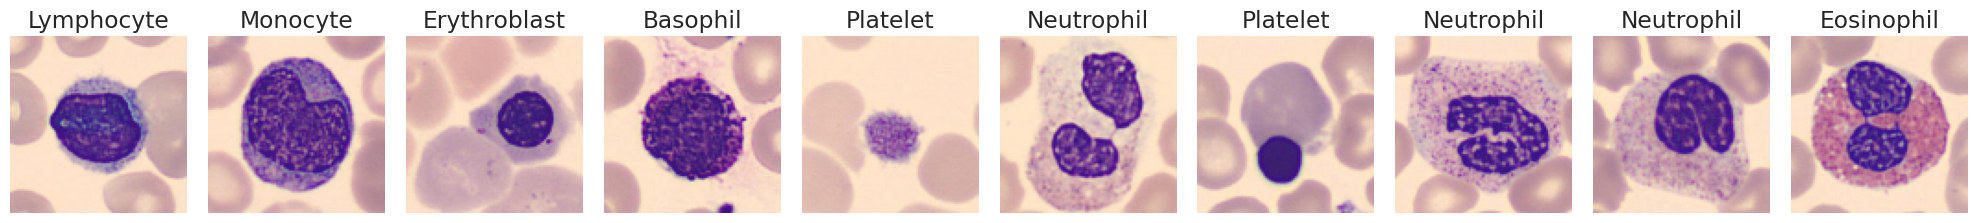

In [ ]:
# Display a sample of images (casual) from the training-validation dataset
import random
import matplotlib.pyplot as plt
num_img = 10
random_indices = random.sample(range(len(X_train_val)), num_img)

fig, axes = plt.subplots(1, num_img, figsize=(20, 20))

# Iterate through the selected number of images
for i, idx in enumerate(random_indices):
    ax = axes[i % num_img]
    ax.imshow(np.squeeze(X_train_val[idx]), vmin=0., vmax=1.)
    ax.set_title(f'{labels[y_train_val[idx][0]]}')
    ax.axis('off')

# Adjust layout and display the images
plt.tight_layout()
plt.show()

In [ ]:
# Further split train_val into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, random_state=seed, test_size=len(X_test), stratify=np.argmax(y_train_val,axis=1))
print(X_train.shape)
print(X_val.shape)
print(y_train.shape)

(7169, 96, 96, 3)
(2391, 96, 96, 3)
(7169, 1)


In [ ]:
print('Counting occurrences of target classes:')
print(pd.DataFrame(y_train, columns=['digit'])['digit'].value_counts())

Counting occurrences of target classes:
digit
6    1429
1    1269
3    1215
7    1007
2     648
5     584
4     526
0     491
Name: count, dtype: int64


In [ ]:
!pip install keras-cv

# Oversampling

In [ ]:
# AUGMENTATION FOR OVERSAMPLING OF THE MINORITY CLASSES: 0, 2, 4, 5
import keras_cv
# Count occurrences of a specific class
target_class = 0
occurrences_target_class = np.sum(y_train == target_class)
print(f"Occurrences of class {target_class} ({labels[target_class]}): {occurrences_target_class}")
class_4_indices = np.where(y_train == target_class)[0]

num_images_to_select = 400 # number of images to augment and duplicate
random_indices = random.sample(list(class_4_indices), num_images_to_select)
augmented_images = []

for index in random_indices:
  img=X_train[index]
  img = img.reshape((1,) + img.shape)

  augmentation = keras_cv.layers.RandAugment(
    value_range=(0, 255),  # range of pixel values in the input images
    augmentations_per_image=2,  # number of random transformations per image
    magnitude=0.2  # strength of transformations
)
  augmented_img = np.clip(augmentation(img), 0., 1.)
  augmented_img = augmented_img.reshape(img.shape[1:])
  augmented_images.append(augmented_img)

augmented_images = np.array(augmented_images)
X_train = np.concatenate((X_train, augmented_images), axis=0)

augmented_labels = np.full(len(augmented_images), target_class)
augmented_labels = augmented_labels.reshape(-1, 1)
y_train = np.concatenate((y_train, augmented_labels), axis=0)

print('Counting occurrences of target classes:')
print(pd.DataFrame(y_train, columns=['digit'])['digit'].value_counts())

Occurrences of class 0 (Basophil): 491
Counting occurrences of target classes:
digit
6    1429
1    1269
3    1215
7    1007
0     891
2     648
5     584
4     526
Name: count, dtype: int64


In [ ]:
import keras_cv

target_class = 2
occurrences_target_class = np.sum(y_train == target_class)
print(f"Occurrences of class {target_class} ({labels[target_class]}): {occurrences_target_class}")
class_4_indices = np.where(y_train == target_class)[0]

num_images_to_select = 400
random_indices = random.sample(list(class_4_indices), num_images_to_select)
augmented_images = []

for index in random_indices:
  img=X_train[index]
  img = img.reshape((1,) + img.shape)

  augmentation = keras_cv.layers.RandAugment(
    value_range=(0, 255),
    augmentations_per_image=2,
    magnitude=0.2
)
  augmented_img = np.clip(augmentation(img), 0., 1.)
  augmented_img = augmented_img.reshape(img.shape[1:])
  augmented_images.append(augmented_img)

augmented_images = np.array(augmented_images)
X_train = np.concatenate((X_train, augmented_images), axis=0)

augmented_labels = np.full(len(augmented_images), target_class)
augmented_labels = augmented_labels.reshape(-1, 1)
y_train = np.concatenate((y_train, augmented_labels), axis=0)

print('Counting occurrences of target classes:')
print(pd.DataFrame(y_train, columns=['digit'])['digit'].value_counts())

Occurrences of class 2 (Erythroblast): 648
Counting occurrences of target classes:
digit
6    1429
1    1269
3    1215
2    1048
7    1007
0     891
5     584
4     526
Name: count, dtype: int64


In [ ]:
import keras_cv

target_class = 5
occurrences_target_class = np.sum(y_train == target_class)
print(f"Occurrences of class {target_class} ({labels[target_class]}): {occurrences_target_class}")
class_4_indices = np.where(y_train == target_class)[0]

num_images_to_select = 400
random_indices = random.sample(list(class_4_indices), num_images_to_select)
augmented_images = []

for index in random_indices:
  img=X_train[index]
  img = img.reshape((1,) + img.shape)

  augmentation = keras_cv.layers.RandAugment(
    value_range=(0, 255),
    augmentations_per_image=2,
    magnitude=0.2
)
  augmented_img = np.clip(augmentation(img), 0., 1.)
  augmented_img = augmented_img.reshape(img.shape[1:])
  augmented_images.append(augmented_img)

augmented_images = np.array(augmented_images)
X_train = np.concatenate((X_train, augmented_images), axis=0)

augmented_labels = np.full(len(augmented_images), target_class)
augmented_labels = augmented_labels.reshape(-1, 1)
y_train = np.concatenate((y_train, augmented_labels), axis=0)

print('Counting occurrences of target classes:')
print(pd.DataFrame(y_train, columns=['digit'])['digit'].value_counts())


Occurrences of class 5 (Monocyte): 584
Counting occurrences of target classes:
digit
6    1429
1    1269
3    1215
2    1048
7    1007
5     984
0     891
4     526
Name: count, dtype: int64


In [ ]:
import keras_cv

target_class = 4
occurrences_target_class = np.sum(y_train == target_class)
print(f"Occurrences of class {target_class} ({labels[target_class]}): {occurrences_target_class}")
class_4_indices = np.where(y_train == target_class)[0]

num_images_to_select = 400
random_indices = random.sample(list(class_4_indices), num_images_to_select)
augmented_images = []

for index in random_indices:
  img=X_train[index]
  img = img.reshape((1,) + img.shape)

  augmentation = keras_cv.layers.RandAugment(
    value_range=(0, 255),
    augmentations_per_image=2,
    magnitude=0.2
)
  augmented_img = np.clip(augmentation(img), 0., 1.)
  augmented_img = augmented_img.reshape(img.shape[1:])
  augmented_images.append(augmented_img)

augmented_images = np.array(augmented_images)
X_train = np.concatenate((X_train, augmented_images), axis=0)

augmented_labels = np.full(len(augmented_images), target_class)
augmented_labels = augmented_labels.reshape(-1, 1)
y_train = np.concatenate((y_train, augmented_labels), axis=0)

print('Counting occurrences of target classes:')
print(pd.DataFrame(y_train, columns=['digit'])['digit'].value_counts())

Occurrences of class 4 (Lymphocyte): 526
Counting occurrences of target classes:
digit
6    1429
1    1269
3    1215
2    1048
7    1007
5     984
4     926
0     891
Name: count, dtype: int64


In [ ]:
# Print the shapes of the final training, validation, and test sets
X_train_def=X_train
y_train_def=y_train
print(X_train_def.shape)
print(y_train_def.shape)
X_val_def=X_val
y_val_def=y_val
print(X_val_def.shape)
print(y_val_def.shape)
X_test_def=X_test
y_test_def= y_test
print(X_test_def.shape)
print(y_test_def.shape)

(8769, 96, 96, 3)
(8769, 1)
(2391, 96, 96, 3)
(2391, 1)
(2391, 96, 96, 3)
(2391, 1)


In [ ]:
y_train_def = np.squeeze(y_train_def)
# Calculate class weights and use them to have a more balanced training process
class_weights = compute_class_weight(
    'balanced',
    classes = np.unique(y_train_def),
    y = y_train_def
)
class_weight_dict = dict(enumerate(class_weights))

In [ ]:
# Convert class labels to categorical format for training, validation, and test sets
y_train_def = tfk.utils.to_categorical(y_train_def, num_classes=8)
y_val_def = tfk.utils.to_categorical(y_val_def, num_classes=8)
y_test_def = tfk.utils.to_categorical(y_test_def, num_classes=8)

print(y_train_def.shape)
print(y_val_def.shape)
print(y_test_def.shape)

(8769, 8)
(2391, 8)
(2391, 8)


# Build the model

In [ ]:
input_shape=(96, 96, 3)
convnext = tfk.applications.ConvNeXtLarge(
      input_shape = input_shape,
      include_top = False,
      pooling='avg',
  )
convnext.trainable = False

785596384/785596384 ━━━━━━━━━━━━━━━━━━━━ 10s 0us/step


In [ ]:
inputs = tfk.Input(shape=(96, 96, 3), name='layer_di_input')

augmentation = tf.keras.Sequential([
    tfkl.RandomFlip("horizontal"),
    tfkl.RandomTranslation(0.3, 0.3),
    tfkl.RandomRotation(0.4),
#    tfkl.RandomBrightness(0.3, value_range=(0,1)), # these transformations significantly make worse the performance metrics
    tfkl.RandomZoom(0.2),
#    tfkl.RandomContrast(0.2)
], name='preprocessing')

x = augmentation(inputs)

# Connect ConvNeXtLarge to the input
x = convnext(x)

x = tfkl.Dense(
    75,
    activation='selu',
    kernel_regularizer=tfk.regularizers.l2(1e-5),
    name="dense_layer")(x)

# LEAKY RELU
leaky_relu_layer = tfkl.LeakyReLU()(x)
x = tfkl.Dropout(0.3, name="drop_layer")(leaky_relu_layer)

# KERNEL REGULARIZATION
outputs = tfkl.Dense(8, activation='softmax', name='output_layer', kernel_regularizer=tfk.regularizers.l2(1e-5))(x)

model = tfk.Model(inputs=inputs, outputs=outputs, name='model')
# Define early stopping
early_stopping = tfk.callbacks.EarlyStopping(
    monitor='val_accuracy', # monitor validation accuracy
    mode='max', # we want to maximize val_accuracy
    patience=15, # number of epochs with no improvement after which training will be stopped
    restore_best_weights=True, # restore model weights from the epoch with the best value of the monitored quantity
    start_from_epoch=15) # starting epoch for monitoring

# Callback function that monitors a specific metric during training
reduce_lr_on_plateau = tfk.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.8,
    patience=5 # number of epochs with no validation loss improvement after which learning rate will be reduced
    )

callbacks = [early_stopping, reduce_lr_on_plateau]

In [ ]:
model.compile(
    optimizer=tfk.optimizers.Lion(learning_rate=0.001), # va a diminuire
    loss=tfk.losses.CategoricalCrossentropy(),
    metrics=['accuracy']
)

# Train the model

In [ ]:
# Train the model
history = model.fit(
    x=X_train_def,
    y=y_train_def,
    batch_size=128,
    epochs=100,
    validation_data = (X_val_def, y_val_def),
    class_weight = class_weight_dict,
    callbacks=callbacks,
).history

# Calculate and print the best validation accuracy achieved
final_val_accuracy = round(max(history['val_accuracy']) * 100, 2)
print(f'Final validation accuracy: {final_val_accuracy}%')

# Save the trained model to a file
model_filename = 'ConvNeXt.keras'
model.save(model_filename)

# Free memory by deleting the model instance
del model

Epoch 1/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 171s 1s/step - accuracy: 0.3740 - loss: 1.9862 - val_accuracy: 0.8394 - val_loss: 0.4859 - learning_rate: 0.0010
Epoch 2/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 79s 1s/step - accuracy: 0.7402 - loss: 0.7012 - val_accuracy: 0.8984 - val_loss: 0.3449 - learning_rate: 0.0010
Epoch 3/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.7653 - loss: 0.6251 - val_accuracy: 0.9201 - val_loss: 0.2969 - learning_rate: 0.0010
Epoch 4/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.7713 - loss: 0.6298 - val_accuracy: 0.9318 - val_loss: 0.2563 - learning_rate: 0.0010
Epoch 5/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.7737 - loss: 0.6181 - val_accuracy: 0.9398 - val_loss: 0.2566 - learning_rate: 0.0010
Epoch 6/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.7798 - loss: 0.6143 - val_accuracy: 0.9473 - val_loss: 0.2539 - learning_rate: 0.0010
Epoch 7/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.7821 - loss: 0.6340 - val_ac

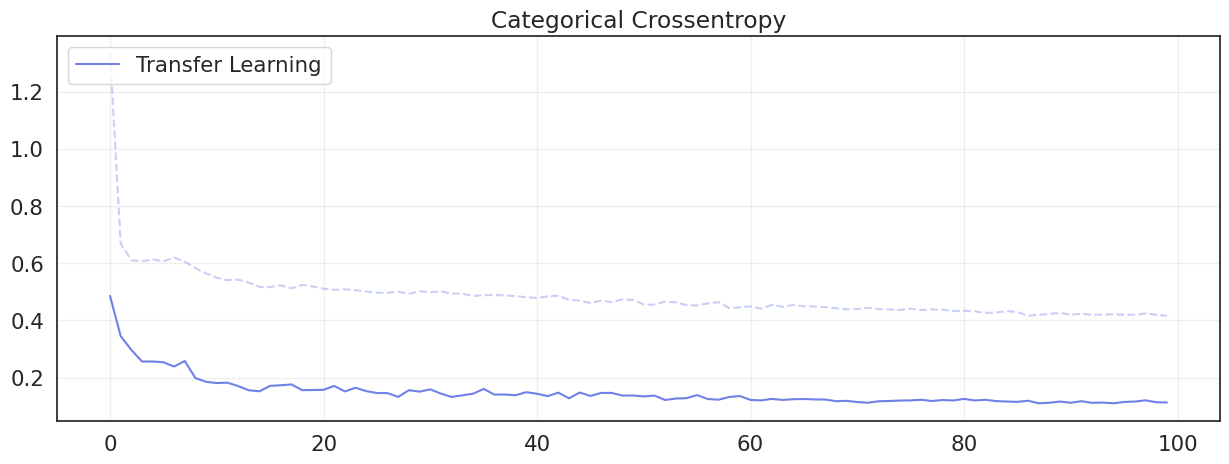

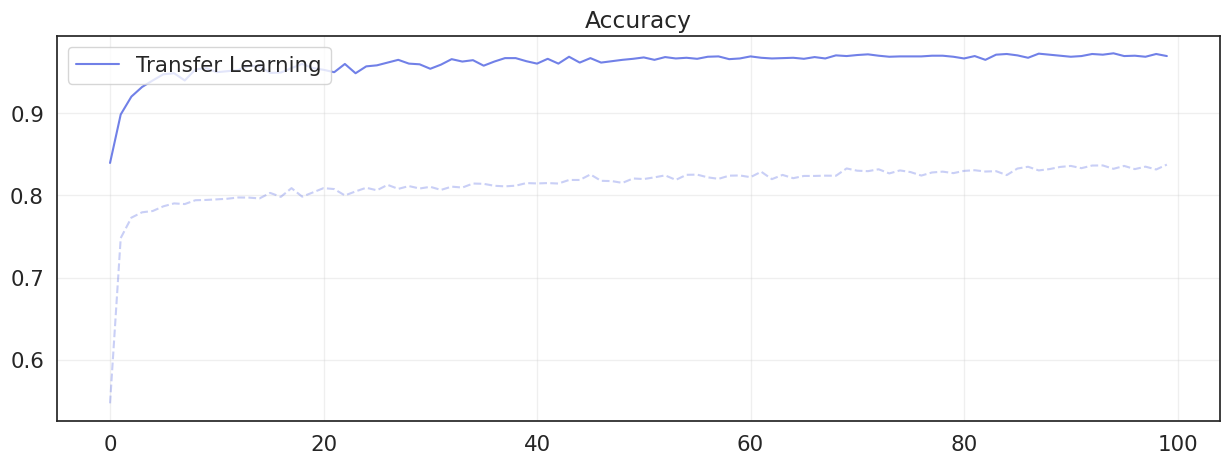

In [ ]:
# Plot the training
plt.figure(figsize=(15,5))
plt.plot(history['loss'], alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(history['val_loss'], label='Transfer Learning', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(history['accuracy'], alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(history['val_accuracy'], label='Transfer Learning', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

# Fine Tuning

Model: "model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ layer_di_input (InputLayer)          │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cast_1 (Cast)                        │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ preprocessing (Sequential)           │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ random_flip (RandomFlip)        │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ random_translation_6400         │ (None, 96, 96, 3)           │               0 │
│ (RandomTranslation)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ random_rotation_1               │ (None, 96, 96, 3)           │               0 │
│ (RandomRotation)                     │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ random_zoom_1 (RandomZoom)      │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ convnext_large (Functional)          │ (None, 1536)                │     196,230,336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ input_layer (InputLayer)        │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └                                 │ (None, 96, 96, 3)           │               0 │
│ convnext_large_prestem_normalization │                             │                 │
│ (Normalization)                      │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ convnext_large_stem             │ (None, 24, 24, 192)         │           9,792 │
│ (Sequential)                         │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│       └ convnext_large_stem_conv     │ (None, 24, 24, 192)         │           9,408 │
│ (Conv2D)                             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│       └                              │ (None, 24, 24, 192)         │             384 │
│ convnext_large_stem_layernorm        │                             │                 │
│ (LayerNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └                                 │ (None, 24, 24, 192)         │           9,600 │
│ convnext_large_stage_0_block_0_dept… │                             │                 │
│ (Conv2D)                             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └                                 │ (None, 24, 24, 192)         │             384 │
│ convnext_large_stage_0_block_0_laye… │                             │                 │
│ (LayerNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 196,462,108 (749.44 MB)

 Trainable params: 115,883 (452.67 KB)

 Non-trainable params: 196,230,336 (748.56 MB)

 Optimizer params: 115,889 (452.70 KB)

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.924525 to fit



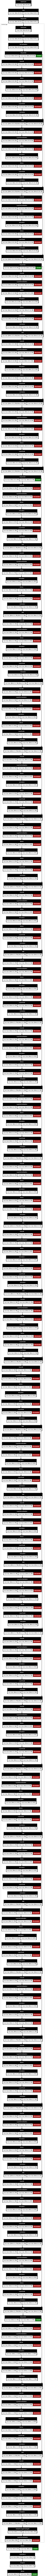

In [ ]:
# Re-load the model after transfer learning
ft_model = tfk.models.load_model('/gdrive/My Drive/[2024-2025] ANN2DL/Homework 1/ConvNeXt.keras')

# Display a summary of the model architecture
ft_model.summary(expand_nested=True)

# Display model architecture with layer shapes and trainable parameters
tfk.utils.plot_model(ft_model, expand_nested=True, show_trainable=True, show_shapes=True, dpi=70)

In [ ]:
# Add regularization
ft_model.get_layer("dense_layer").kernel_regularizer = tfk.regularizers.L1L2(1e-2, 1e-2)
ft_model.get_layer("output_layer").kernel_regularizer = tfk.regularizers.L2(1e-5)

In [ ]:
# Set all layers trainable, temporary
ft_model.get_layer('convnext_large').trainable = True

In [ ]:
from keras.optimizers import Lion

early_stopping = tfk.callbacks.EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=8,
    restore_best_weights=True)
callbacks = [early_stopping]

In [ ]:
# Define a learning rate schedule
lr_schedule = tfk.optimizers.schedules.ExponentialDecay(
     initial_learning_rate=1e-5,  # Start with this learning rate
     decay_steps=700,           # After how many steps to apply decay
     decay_rate=0.7,            # Decay rate
     staircase=True)
# Define the optimizer with the schedule
optimizer = tfk.optimizers.Lion(learning_rate=lr_schedule)

# Compile the model for the fine tuning
def compile_model(model):
    model.compile(
        loss=tfk.losses.CategoricalCrossentropy(),
        optimizer=optimizer,
        metrics=['accuracy']
    )
    return model

compile_model(ft_model)
ft_model.summary()


Model: "model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ layer_di_input (InputLayer)          │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cast_1 (Cast)                        │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ preprocessing (Sequential)           │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ convnext_large (Functional)          │ (None, 1536)                │     196,230,336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_layer (Dense)                  │ (None, 75)                  │         115,275 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 75)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ drop_layer (Dropout)                 │ (None, 75)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (Dense)                 │ (None, 8)                   │             608 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 196,346,219 (749.00 MB)

 Trainable params: 190,137,899 (725.32 MB)

 Non-trainable params: 6,208,320 (23.68 MB)

In [ ]:
# Enable training only for the last N layers, the earlier ones remain freezed
def unfreeze_model_layers(model, N):
    for layer in ft_model.get_layer('convnext_large').layers[:-N]:
        layer.trainable = False
    for layer in ft_model.get_layer('convnext_large').layers[-N:]:
   #   if isinstance(layer, tf.keras.layers.Conv2D) or isinstance(layer, tf.keras.layers.DepthwiseConv2D):
        layer.trainable = True

    print(f"Unlocked: {sum(layer.trainable for layer in ft_model.get_layer('convnext_large').layers)}/{len(ft_model.get_layer('convnext_large').layers)}")

In [ ]:
unfreeze_model_layers(ft_model, 70)
# Perform the fine-tuning
ft_history = ft_model.fit(
    x=X_train_def,
    y=y_train_def,
    batch_size=64,
    class_weight = class_weight_dict,
    epochs=80,
    validation_data=(X_val_def, y_val_def),
    callbacks=callbacks
).history

# Calculate the final validation accuracy
final_val_accuracy = round(max(ft_history['val_accuracy']) * 100, 2)
print(f'Final validation accuracy: {final_val_accuracy}%')

model_filename = f'weights.keras'
ft_model.save(model_filename)

del ft_model

Unlocked: 70/260
Epoch 1/80
138/138 ━━━━━━━━━━━━━━━━━━━━ 204s 1s/step - accuracy: 0.8244 - loss: 0.4455 - val_accuracy: 0.9645 - val_loss: 0.1335
Epoch 2/80
138/138 ━━━━━━━━━━━━━━━━━━━━ 189s 1s/step - accuracy: 0.8257 - loss: 0.4485 - val_accuracy: 0.9691 - val_loss: 0.1250
Epoch 3/80
138/138 ━━━━━━━━━━━━━━━━━━━━ 207s 1s/step - accuracy: 0.8249 - loss: 0.4326 - val_accuracy: 0.9640 - val_loss: 0.1263
Epoch 4/80
138/138 ━━━━━━━━━━━━━━━━━━━━ 202s 1s/step - accuracy: 0.8295 - loss: 0.4311 - val_accuracy: 0.9640 - val_loss: 0.1295
Epoch 5/80
138/138 ━━━━━━━━━━━━━━━━━━━━ 202s 1s/step - accuracy: 0.8344 - loss: 0.4177 - val_accuracy: 0.9749 - val_loss: 0.1130
Epoch 6/80
138/138 ━━━━━━━━━━━━━━━━━━━━ 171s 1s/step - accuracy: 0.8390 - loss: 0.4097 - val_accuracy: 0.9732 - val_loss: 0.1161
Epoch 7/80
138/138 ━━━━━━━━━━━━━━━━━━━━ 202s 1s/step - accuracy: 0.8346 - loss: 0.4063 - val_accuracy: 0.9753 - val_loss: 0.1109
Epoch 8/80
138/138 ━━━━━━━━━━━━━━━━━━━━ 195s 1s/step - accuracy: 0.8346 - loss: 

# Make Inference

Accuracy score over the test set: 0.9824
Precision score over the test set: 0.9826
Recall score over the test set: 0.9824
F1 score over the test set: 0.9825


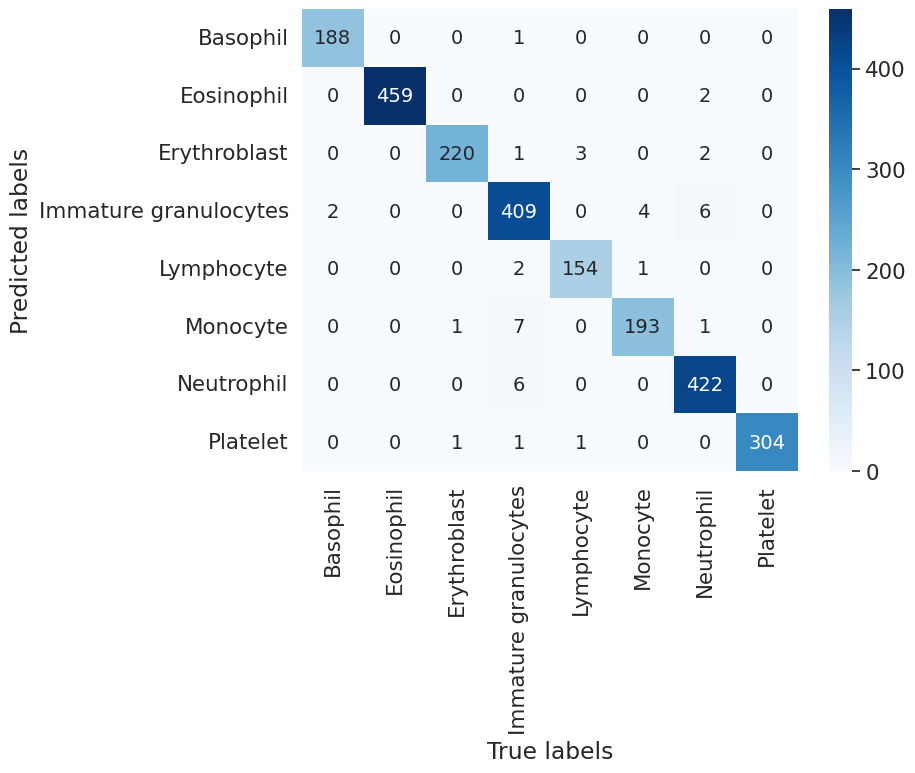

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Load the saved model
model = tfk.models.load_model('weights.keras')

# Predict class probabilities and get predicted classes
test_predictions = model.predict(X_test_def, verbose=0)
test_predictions = np.argmax(test_predictions, axis=-1)
# argmax fa il contrario di one-hot, ovvero riporta le previsioni nella normale calssificazione (in questo caso da 0 a 7) (bu)

# Extract ground truth classes
test_gt = np.argmax(y_test_def, axis=-1)

# Calculate and display test set accuracy
test_accuracy = accuracy_score(test_gt, test_predictions)
print(f'Accuracy score over the test set: {round(test_accuracy, 4)}')

# Calculate and display test set precision
test_precision = precision_score(test_gt, test_predictions, average='weighted')
print(f'Precision score over the test set: {round(test_precision, 4)}')

# Calculate and display test set recall
test_recall = recall_score(test_gt, test_predictions, average='weighted')
print(f'Recall score over the test set: {round(test_recall, 4)}')

# Calculate and display test set F1 score
test_f1 = f1_score(test_gt, test_predictions, average='weighted')
print(f'F1 score over the test set: {round(test_f1, 4)}')
# Compute the confusion matrix
cm = confusion_matrix(test_gt, test_predictions)

# Create labels combining confusion matrix values
labels = np.array([f"{num}" for num in cm.flatten()]).reshape(cm.shape)

# Plot the confusion matrix with class labels
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=labels, fmt='', xticklabels=['Basophil', 'Eosinophil', 'Erythroblast', 'Immature granulocytes', 'Lymphocyte', 'Monocyte', 'Neutrophil', 'Platelet'], yticklabels=['Basophil', 'Eosinophil', 'Erythroblast', 'Immature granulocytes', 'Lymphocyte', 'Monocyte', 'Neutrophil', 'Platelet'], cmap='Blues')
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

del model

In [ ]:
%%writefile model.py
import numpy as np

import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl


class Model:
    def __init__(self):
        """
        Initialize the internal state of the model. Note that the __init__
        method cannot accept any arguments.

        The following is an example loading the weights of a pre-trained
        model.
        """
        self.neural_network = tfk.models.load_model('weights.keras')

    def predict(self, X):
        """
        Predict the labels corresponding to the input X. Note that X is a numpy
        array of shape (n_samples, 96, 96, 3) and the output should be a numpy
        array of shape (n_samples,). Therefore, outputs must no be one-hot
        encoded.

        The following is an example of a prediction from the pre-trained model
        loaded in the __init__ method.
        """
        preds = self.neural_network.predict(X)
        if len(preds.shape) == 2:
            preds = np.argmax(preds, axis=1)
        return preds

Writing model.py


In [ ]:
from datetime import datetime
filename = f'submission_{datetime.now().strftime("%y%m%d_%H%M%S")}_final_ConvNeXtL.zip'

# Add files to the zip command if needed
!zip {filename} model.py weights.keras

from google.colab import files
files.download(filename)

  adding: model.py (deflated 56%)
  adding: weights.keras (deflated 6%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>